### Analysis and plotting

In [48]:
import pandas as pd
import numpy as np
import xarray as xr
import os

# for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

# for plotting ASTER geotiffs
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.warp import calculate_default_transform

# for working with raster data
import rioxarray

# for shapefile
import geopandas as gpd

# for calculating zonal statistics
import aster_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

In [3]:
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

Set font sizes for plots

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---
## Open data files

---
---
Open our merged GOES-CUES point timeseries dataset

In [5]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

Load MODIS observations of the CUES site

In [6]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

Get filepaths for orthorectified GOES images

In [7]:
goes_directory = "/storage/GOES/orthorectified"
ortho_goes_filelist = getListOfFiles(goes_directory)

In [8]:
ortho_goes_filelist

['/storage/GOES/orthorectified/2017/03/4/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20170631847509_e20170631850282_c20170631850319_orthorectified.nc',
 '/storage/GOES/orthorectified/2017/03/4/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20170631847509_e20170631850282_c20170631850319_orthorectified.tif',
 '/storage/GOES/orthorectified/2017/03/4/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20170631847509_e20170631850282_c20170631850319_orthorectified.tif.aux.xml',
 '/storage/GOES/orthorectified/2017/03/20/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20170791847510_e20170791850283_c20170791850328_orthorectified.nc',
 '/storage/GOES/orthorectified/2017/03/20/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20170791847510_e20170791850283_c20170791850328_orthorectified.tif',
 '/storage/GOES/orthorectified/2017/03/20/ABI-L1b-RadC/18/C14/OR_ABI-L1b-RadC-M3C14_G16_s20170791847510_e20170791850283_c20170791850328_orthorectified.tif.aux.xml',
 '/storage/GOES/orthorectified/2017/04/21/ABI-L

When do we have ASTER observations of this site?

In [9]:
# Find all our ASTER files for the CUES site
directory = "/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES"
aster_files = getListOfFiles(directory)

## Parse the date and time from ASTER filenames
aster_datetimes = []
aster_datetimes_UTC = []
for fpath in aster_files:
    fn = fpath.split('/')[-1] # non-re method
    MM = fn.split('_')[2][3:5]
    DD = fn.split('_')[2][5:7]
    YYYY = fn.split('_')[2][7:11]
    hh = fn.split('_')[2][11:13]
    mm = fn.split('_')[2][13:15]
    ss = fn.split('_')[2][15:17]
    aster_datetimes_UTC.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss),tz='UTC'))
    aster_datetimes.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss),tz='UTC')- pd.Timedelta(8, unit='hours'))

aster = pd.DataFrame({'datetime': aster_datetimes, 'datetimeUTC': aster_datetimes_UTC, 'filepath': aster_files})
aster.sort_values('datetime',inplace=True)
aster.reset_index(inplace=True, drop=True)

In [10]:
# create an empty dictionary we'll fill with filenames and timestamps for each subdirectory we search
goes_dict = {}
    

aster_counter = 0
# for every ASTER datetime (in UTC)
for aster_datetime_UTC in aster.datetimeUTC:
    # count
    aster_counter += 1
    print('\n\n File {} of {}'.format(aster_counter, aster.shape[0]))
    print('\nFor ASTER observation at {}'.format(aster_datetime_UTC))
    # find the GOES subdirectory for the corresponding year-month-day and hour
    goes_subdir = r"/{year}/{month}/{day}/{product}/{hour}/{channel}/".format(
                            goes_directory=goes_directory, 
                            year=aster_datetime_UTC.strftime('%Y'), 
                            month=aster_datetime_UTC.strftime('%m'), 
                            day=aster_datetime_UTC.day, 
                            product='ABI-L1b-RadC', 
                            hour=aster_datetime_UTC.strftime('%H'), 
                            channel='C14')
    # now within this subdirectory, the same hour of this ASTER observation
    print('\nSearching for GOES ABI imagery within:\n{}{}'.format(goes_directory,goes_subdir))
    # get the filenames of each GOES ABI image in this subdirectory
    goes_files = getListOfFiles(os.path.normpath(goes_directory+goes_subdir))
    goes_datetimes_UTC_list = []
    goes_files_list = []
    

    for this_goes_file in goes_files:

        this_goes_filename = os.path.normpath(this_goes_file).split('\\')[-1]
        if this_goes_filename.split('.')[-1] == 'tif':
            
            # parse the timstamp in the filename 
            this_goes_datetime_UTC = this_goes_filename.split('_')[-2].split('.')[0][1:-1]
            #print(this_goes_datetime_UTC)
            this_goes_datetime_UTC = pd.to_datetime(this_goes_datetime_UTC, format="%Y%j%H%M%S")
            this_goes_datetime_UTC = pd.Timestamp(this_goes_datetime_UTC, tz='UTC')
            #print('\t{}'.format(this_goes_datetime_UTC))

            # add these to our dictionary, use the date as the key
            goes_dict[this_goes_datetime_UTC] = {}
            goes_dict[this_goes_datetime_UTC]['filepath'] = this_goes_file



 File 1 of 56

For ASTER observation at 2017-03-04 18:51:03+00:00

Searching for GOES ABI imagery within:
/storage/GOES/orthorectified/2017/03/4/ABI-L1b-RadC/18/C14/


 File 2 of 56

For ASTER observation at 2017-03-20 18:51:06+00:00

Searching for GOES ABI imagery within:
/storage/GOES/orthorectified/2017/03/20/ABI-L1b-RadC/18/C14/


 File 3 of 56

For ASTER observation at 2017-04-21 18:51:07+00:00

Searching for GOES ABI imagery within:
/storage/GOES/orthorectified/2017/04/21/ABI-L1b-RadC/18/C14/


 File 4 of 56

For ASTER observation at 2017-05-23 18:51:10+00:00

Searching for GOES ABI imagery within:
/storage/GOES/orthorectified/2017/05/23/ABI-L1b-RadC/18/C14/


 File 5 of 56

For ASTER observation at 2017-06-07 06:07:10+00:00

Searching for GOES ABI imagery within:
/storage/GOES/orthorectified/2017/06/7/ABI-L1b-RadC/06/C14/


 File 6 of 56

For ASTER observation at 2017-06-07 06:07:19+00:00

Searching for GOES ABI imagery within:
/storage/GOES/orthorectified/2017/06/7/ABI-L1b-Ra

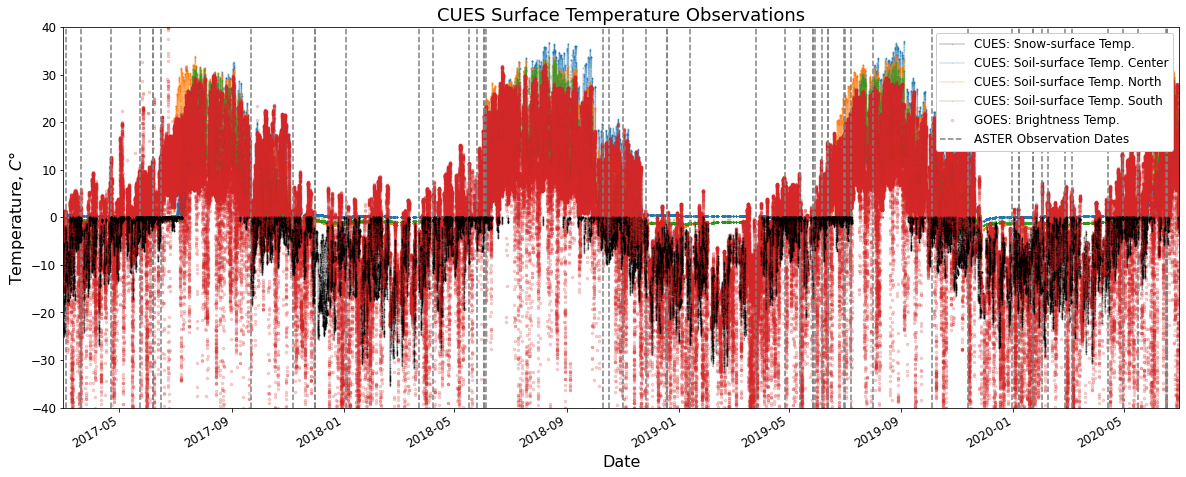

In [11]:
# Set start and end dates for time period we want to look at
startdate = cues_ds.datetime.min().values
enddate = cues_ds.datetime.max().values
#startdate = pd.Timestamp('2017-03-20')
#enddate = pd.Timestamp('2017-03-21')

alpha = 0.2
condition = cues_ds.cloud_flag==0

# Set up figure
fig, ax = plt.subplots(figsize=(20,7))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)

# Plot CUES soil surface temperature
cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)

# Plot GOES brightness temperature
cues_ds.goes_tb_c.where(condition).plot(c='tab:red', linestyle='none', marker='.', markersize=5, ax=ax, alpha=alpha)

# Plot when we have ASTER observations of the CUES site
for aster_datetime in aster.datetime:
    plt.axvline(x=aster_datetime, color='grey', linestyle='--')

ax.set_xlim([startdate,enddate])
ax.set_ylim([-40,40])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Date')

# Make legend
lines = [ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3], ax.lines[4], ax.lines[5]]
labels = ['CUES: Snow-surface Temp.', 
          'CUES: Soil-surface Temp. Center', 
          'CUES: Soil-surface Temp. North', 
          'CUES: Soil-surface Temp. South',
          'GOES: Brightness Temp.',
         'ASTER Observation Dates']
ax.legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)

# Set title
plt.title('CUES Surface Temperature Observations');



# Save figure image
#plt.savefig('goes-cues-Mar2017-Jun2020.jpg',dip=300);

## For comparison with ASTER

Look at all of our ASTER observations on a timeline

to do:
* calculate zonal statistics for each

In [12]:
#aster_subset = aster.loc[[0,5,10,15,20,25,31,35]]
#aster_subset.reset_index(inplace=True)

In [13]:
aster_subset = aster

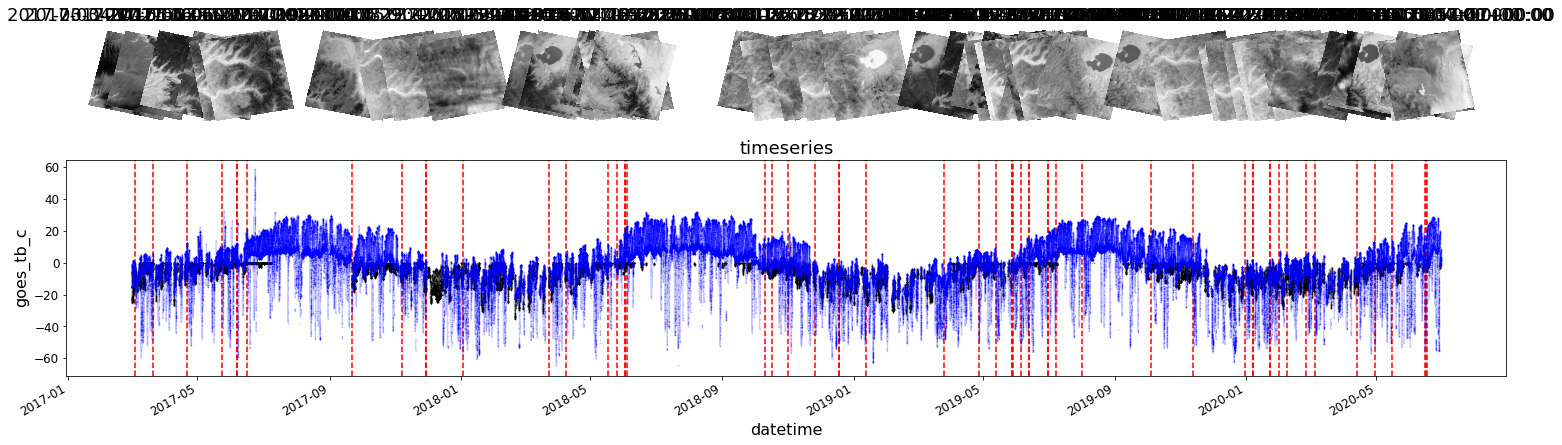

In [14]:
n_total = aster_subset.shape[0]

fig, ax = plt.subplots(figsize=(20,5))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)
# Plot GOES brightness temp timeseries
cues_ds.goes_tb_c.where(condition).plot(
    c='b', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)
ax.set_position([0, 0, 1, 0.6])
ax.set_title('timeseries')



for n in range(n_total):

    # draw a vertical line at the ASTER observation date
    ax.axvline(aster_subset.datetime[n], c='r', linestyle='--')
    
    # Inset plot
    inset_plot_width = 0.25 + 1/n_total
    inset_plot_height = 0.25 + 1/n_total
    
    
    # transform from data coordinates (x=datetime64, y=temperature) into display coordinates (pixels)
    xdisplay, ydisplay = ax.transData.transform((mdates.date2num(aster_subset.datetime[n]),0))
    # create an inverse transform from display coordinates (pixels) into figure coordinates (fractions)
    inv = fig.transFigure.inverted()
    # apply the inverse transform
    inset_plot_xpos, _ = inv.transform((xdisplay, ydisplay))
    
    #inset_plot_xpos = np.linspace(0, 1-(1/n_total), n_total)[n] # x coordinate for evenly spaced images
    inset_plot_ypos = 0.7 # fixed y coordinate
    
    current_ax = fig.add_axes([inset_plot_xpos - (inset_plot_width/2), inset_plot_ypos, 
                               inset_plot_width, inset_plot_height], 
                              facecolor='k')
    current_ax.set_title('{}'.format(aster_subset.datetime[n]))
    current_ax.axis('off')
    
    fpath = os.path.normpath(aster_subset.filepath[n])
    with rio.open(fpath) as src:
        a = src.read(1)
        a = a.astype('float32')
        a[a==0] = np.nan
        current_ax.imshow(a, cmap='Greys_r')



### For each day we're interested in with an ASTER observation:

Create plots to take a look in more detail for days with ASTER observations

I'm including all data points here (not filtering out cloudy periods)


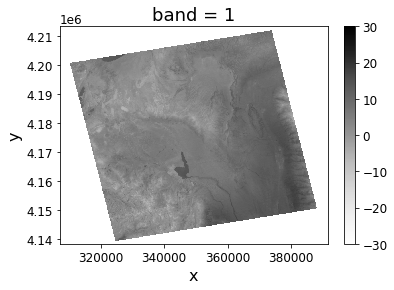

In [131]:
fig, ax = plt.subplots()

### Open the ASTER image
aster_src = xarray.open_rasterio(single_filepath)
# Replace the nodatavals with NaN
aster_src = aster_src.where(aster_src!=aster_src.nodatavals, np.nan)
# Convert ASTER DN to Radiance, and then Brightness Temperature
aster_rad = aster_utils.tir_dn2rad(aster_src, aster_band)
aster_tb =  aster_utils.tir_rad2tb(aster_rad, aster_band)
aster_tb_degC = aster_tb-273.15

### plot ASTER image
aster_tb_degC.plot(ax=ax, cmap='Greys', vmin=-30, vmax=30)


In [ ]:
x = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
x_label = 'CUES Snow-Surface Temp. [$\degree C$]'

y = cues_ds.goes_tb_c
y_label = 'GOES Brightness Temp. [$\degree C$]'

t = cues_ds.datetime

snowdepth = cues_ds['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)']

aster_band = 14

# initialize the orbit_change_flag to false until GOES-16 changes orbits
orbit_change_flag = False

for index, row in aster.iterrows():
    
    
    
    
    # Get the filepath to the ASTER image
    single_filepath = os.path.normpath(row.filepath)    
    # Get the datetime of the ASTER image
    single_datetime = row.datetime
    # Get the beginning of the day
    startdate = pd.Timestamp(single_datetime.strftime("%Y-%m-%d"))
    # Get the end of the day
    enddate = startdate + pd.Timedelta(hours=24)
       
    
    
    ### Compute zonal statistics with on the ASTER image ###
    # GOES-16 changed orbital slots in late 2017, choose the corresponding GOES pixel footprint
    if (startdate < pd.Timestamp(year=2017,month=12,day=1)) and (orbit_change_flag==False):
        # Before December 2017, GOES-16 was at about -89 longitude
        # load the GOES pixel footprint shapefile for this orbital position
        shapefile_filepath = "shapefiles/CUES_lon_89_west.shp"
        zone_shape = gpd.read_file(shapefile_filepath)
    else:
        # Since December 2017, GOES-16 has been at about -75 longitude (GOES-East slot)
        # load the GOES pixel footprint shapefile for this orbital position
        shapefile_filepath = "shapefiles/CUES_lon_75_west.shp"
        zone_shape = gpd.read_file(shapefile_filepath)
        # set the orbit_change_flag to true so we don't load the shapefile again
        orbit_change_flag = True
    # Try to compute zonal statistics
    try:
        aster_mean, aster_max, aster_min, aster_std, masked_aster_tb = aster_utils.zonal_stats(single_filepath, 
                                                                                               aster_band,
                                                                                               shapefile_filepath,
                                                                                               return_masked_array=True)
    except TypeError as e:
        # we can get a "TypeError 'NoneType' object is not iterable" when shapefile doesn't overlap raster
        print("Got {} for ASTER at {}\n(likely that the shapefile doesn't intersect the ASTER image)".format(e, aster.datetime[index]))
        continue    
    ######
    
    
    
    ### select a single 24-hour period from our data
    _x = x.sel(datetime=slice(startdate, enddate))
    _y = y.sel(datetime=slice(startdate, enddate))
    # Find the nearest data points to when our ASTER image was taken
    _x_nearest_aster = x.sel(datetime=np.datetime64(single_datetime),method='nearest')
    _y_nearest_aster = y.sel(datetime=np.datetime64(single_datetime),method='nearest')
    #print(_x_nearest_aster.values,_y_nearest_aster.values)
    _t = t.sel(datetime=slice(startdate, enddate))
    _snowdepth = snowdepth.sel(datetime=slice(startdate, enddate))
    ######
    
    
    
    ### Set up plot
    fig, ax = plt.subplots(nrows=1, ncols=7, 
                           figsize=(40,5),
                           tight_layout=True,
                           gridspec_kw={'width_ratios': [1, 2, 1, 1, 1, 1, 1]})
    #fig.suptitle('{}'.format(single_datetime.strftime("%Y-%m-%d")))
    ######
    
    
    ### Plot GOES Tb versus CUES Tss
    ax[0].plot(_x,_y,'.',color='k',markersize=5,alpha=0.5)
    # Highlight the datpoint that coincides with ASTER flying overhead
    ax[0].plot(_x_nearest_aster,_y_nearest_aster,'o',color='r',markersize=5,alpha=1)
    # Plot 1-to-1 line
    ax[0].plot([-30,30],[-30,30],':k')
    # add gridlines
    ax[0].grid(color='grey', linestyle=':', linewidth=1)
    # Set axes limits
    ax[0].set_xlim([-30,30])
    ax[0].set_ylim([-30,30])
    # Set axes labels, plot title
    ax[0].set_ylabel(y_label)
    ax[0].set_xlabel(x_label)
    ax[0].set_title('GOES Tb vs CUES Tss\nDay of {}'.format(single_datetime.strftime("%Y-%m-%d")))
    ######
    
    
    ### Plot timeseries of both
    ax[1].set_title('Day of {}'.format(single_datetime.strftime("%Y-%m-%d")))
    ax[1].grid(color='grey', linestyle=':', linewidth=1)
    ax[1].plot(_t, _x, '.k')
    ax[1].plot(_t, _y, '.b')
    #ax[1].axvline(single_datetime,linestyle='--',color='r')
    ax[1].set_ylim([-30,30])
    ax[1].set_ylabel("Temperature [$\degree C$]")
    ax[1].set_xlabel("Date and Time [UTC-8]")
    ## plot snowdepth
    #ax2 = ax[1].twinx()
    #ax2.plot(_t, _snowdepth, '.', c='tab:grey')
    #ax2.set_ylim([0,600])
    #ax2.set_ylabel("Snow Depth [cm]")
    ######
    
    
    ### add ASTER zonal stats data to timeline plot
    ax[1].plot(np.datetime64(single_datetime),aster_mean-273.15,'o',color='r',markersize=10,label='ASTER Tb mean')
    ax[1].errorbar(np.datetime64(single_datetime),aster_mean-273.15,
                 yerr=[[np.abs(aster_min-aster_mean)],[np.abs(aster_max-aster_mean)]],
                 linestyle='-',c='r',linewidth=2,capsize=4,alpha=0.5)#,
                 #label='ASTER LST Range')
    # make legend for the timeline plot
    lines = [ax[1].lines[0], ax[1].lines[1], ax[1].lines[2]]
    labels = ['CUES: Snow-surface Temp.', 'GOES: Brightness Temp.', 
              'ASTER: Brightness Temp.', 'ASTER: Min - Max $T_B$']
    ax[1].legend(lines, labels, loc='upper left')
    ######


    
    
    
    ### Open the ASTER image
    aster_src = xarray.open_rasterio(single_filepath)
    # Replace the nodatavals with NaN
    aster_src = aster_src.where(aster_src!=aster_src.nodatavals, np.nan)
    # Convert ASTER DN to Radiance, and then Brightness Temperature
    aster_rad = aster_utils.tir_dn2rad(aster_src, aster_band)
    aster_tb =  aster_utils.tir_rad2tb(aster_rad, aster_band)
    aster_tb_degC = aster_tb-273.15
    ######
    
    

    ### plot ASTER image
    aster_tb_degC.plot(ax=ax[2], cmap='Greys', vmin=-30, vmax=30)
    # set labels
    ax[2].set_ylabel('UTM N, Z11N [m]')
    ax[2].set_xlabel('UTM E, Z11N [m]')
    ax[2].set_title('ASTER L1T Band 14')
    # Add scalebar
    scalebar = ScaleBar(1, length_fraction=0.15) # get image resolution from original raster image (1 pixel = X meters)
    ax[2].add_artist(scalebar) 
    # Plot shapefile outline
    zone_shape = zone_shape.to_crs(aster_src.crs)
    zone_shape.plot(ax=ax[2], color="none", ec='red', linewidth=2, linestyle='-', alpha=1)
    # Center this plot on the shapefile
    center_x = zone_shape.geometry.centroid.x.values[0]
    center_y = zone_shape.geometry.centroid.y.values[0]
    ax[2].set_xlim([center_x-40000, center_x+40000])
    ax[2].set_ylim([center_y-40000, center_y+40000])
    # Set the title for this ASTER plot
    title_text = 'ASTER Band 14 $T_B$ at\n{}'.format(aster.datetime[index].strftime("%Y-%m-%d %H:%M"))
    ax[2].set_title(title_text)
    ######
    
    
    
    ### Plot ASTER image cropped to shapefile
    aster_inset_ax = inset_axes(ax[2],
                                width=1,
                                height=1,
                                loc=4)
    rio.plot.show(masked_aster_tb-273.15,
                  ax=aster_inset_ax,
                  cmap='Greys',
                  vmin=-30, vmax=30)
    #scalebar = ScaleBar(src.res[0]) # get image resolution from original raster image
    #aster_inset_ax.add_artist(scalebar)
    aster_inset_ax.tick_params(axis='both', bottom=False, top=False, left=False, right=False)
    aster_inset_ax.xaxis.set_ticklabels([])
    aster_inset_ax.yaxis.set_ticklabels([])
    ######
    
    
    ### Plot histogram and summary statistics
    if aster_mean is not None:
        summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(aster_mean-273.15,1),
                                                                     np.round(aster_max-273.15,1),
                                                                     np.round(aster_min-273.15,1),
                                                                     np.round(aster_std,1))
    
        ax[3].grid(color='grey', linestyle=':', linewidth=1)
        # flattened array to make a histogram
        mased_aster_tb_values = masked_aster_tb.flatten()
        # set up the number of bins to have a width of 0.5 degree (have to remove nans first)
        mased_aster_tb_values_nonan = mased_aster_tb_values[~np.isnan(mased_aster_tb_values)]
        bin_width = 0.5
        n_bins = int(np.round((mased_aster_tb_values_nonan.max() - mased_aster_tb_values_nonan.min())/bin_width, 0)) if len(mased_aster_tb_values_nonan)>0 else 50
        # plot the histogram
        ax[3].hist(mased_aster_tb_values-273.15, bins=n_bins, facecolor='k');
        aster_mean_line = ax[3].axvline(x=aster_mean-273.15, c='r', linestyle='--') # ASTER mean Tb
        goes_line = ax[3].axvline(x=_y_nearest_aster, c='b', linestyle='--') # GOES pixel Tb
        # difference between ASTER mean Tb and GOES Tb (GOES - ASTER)
        tb_diff = _y_nearest_aster.values - (aster_mean-273.15)
        spancolor = 'red' if tb_diff > 1 else 'blue' # conditional fill color if GOES is > or < ASTER mean
        difference_span = ax[3].axvspan(aster_mean-273.15, _y_nearest_aster, alpha=0.2, color=spancolor) # area between ASTER mean Tb and GOES pixel Tb
        ax[3].set_xlim([-15,15])
        ax[3].set_ylim([0,300])
        ax[3].text(7.5,100,summary_stats, bbox=dict(facecolor='white', alpha=0.5))
        ax[3].set_ylabel('Pixel Count')
        ax[3].set_xlabel('Brightness Temperature [$\degree C$]')
        title_text_hist = 'ASTER Band 14 $T_B$ Histogram at\n{}'.format(aster.datetime[index].strftime("%Y-%m-%d %H:%M"))
        ax[3].set_title(title_text_hist)
        # make legend for the histogram plot
        lines = [aster_mean_line, goes_line, difference_span]
        labels = ['ASTER Mean Brightness Temp.', 'GOES: Brightness Temp.', 
                  'Difference: {} $\degree C$'.format(np.round(tb_diff,1))]
        ax[3].legend(lines, labels, loc='upper left')
        ######
    
    

        
        
        
        
        ### Get GOES image
        # Find the GOES image closest to our ASTER observation
        nearest_goes_datetime_UTC = nearest(list(goes_dict.keys()), row.datetimeUTC)
        #print('\t{} -- {}'.format(aster_datetime_UTC, nearest_goes_datetime_UTC))
        nearest_goes_filepath = goes_dict[nearest_goes_datetime_UTC]['filepath']
        # Open the GOES file
        goes_src = xarray.open_rasterio(nearest_goes_filepath)
        # use Reproject_Match to reproject the GOES geotiff into the same CRS as the ASTER geotiff
        goes_src_repr_match = goes_src.rio.reproject_match(aster_src)
        ######
        
        ### plot GOES image
        goes_img_degC = goes_src_repr_match.squeeze()-273.15
        goes_img_degC.plot(ax=ax[4], cmap='Greys', vmin=-30, vmax=30)
        ## set labels
        ax[4].set_ylabel('UTM N, Z11N [m]')
        ax[4].set_xlabel('UTM E, Z11N [m]')
        ax[4].set_title('GOES ABI Band 14 at \n{} UTC'.format(nearest_goes_datetime_UTC))
        ## Add scalebar
        scalebar = ScaleBar(1, length_fraction=0.15) # get image resolution from original raster image (1 pixel = X meters)
        ax[4].add_artist(scalebar) 
        ## Plot shapefile outline
        zone_shape.plot(ax=ax[4], color="none", ec='red', linewidth=2, linestyle='-', alpha=1)
        ## Center this plot on the shapefile
        ax[4].set_xlim([center_x-40000, center_x+40000])
        ax[4].set_ylim([center_y-40000, center_y+40000])
        ######
        
        ### GOES-ASTER difference
        # Subtract GOES - ASTER ~11 micron band Brightness Temperature
        goes_aster_difference = goes_src_repr_match - aster_tb
        # Plot difference image
        goes_aster_difference.plot(ax=ax[5], cmap='RdBu_r', vmin=-30, vmax=30)
        ## Plot shapefile outline
        zone_shape.plot(ax=ax[5], color="none", ec='red', linewidth=2, linestyle='-', alpha=1)
        ## Center this plot on the shapefile
        ax[5].set_xlim([center_x-40000, center_x+40000])
        ax[5].set_ylim([center_y-40000, center_y+40000])
        ax[5].set_title('GOES - ASTER Brightness\nTemperature Difference')
        ######
        
        ### Plot difference histogram and stats
        ax[6].grid(color='grey', linestyle=':', linewidth=1)
        # flattened array to make a histogram
        goes_aster_difference_flat = goes_aster_difference.values.flatten()
        # set up the number of bins to have a width of 0.5 degree (have to remove nans first)
        goes_aster_difference_flat_nonan = goes_aster_difference_flat[~np.isnan(goes_aster_difference_flat)]
        bin_width = 0.5
        n_bins = int(np.round((goes_aster_difference_flat_nonan.max() - goes_aster_difference_flat_nonan.min())/bin_width, 0)) if len(goes_aster_difference_flat_nonan)>0 else 50
        # plot the histogram
        ax[6].hist(goes_aster_difference_flat_nonan, bins=n_bins, facecolor='k');
        ax[6].axvline(0,color='grey',linestyle='--')
        ax[6].axvline(tb_diff,color='r',linestyle='--')
        ax[6].set_xlim([-30,30])
        ax[6].set_ylim([0,60000])
        ax[6].set_title('GOES - ASTER Brightness\nTemperature Difference')
        ax[6].set_ylabel('Pixel Count')
        ax[6].set_xlabel('Brightness Temperature Difference [K]')
        # mean, median, min, max, std
        diff_summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(goes_aster_difference_flat_nonan.mean(),1),
                                                                          np.round(goes_aster_difference_flat_nonan.max(),1),
                                                                          np.round(goes_aster_difference_flat_nonan.min(),1),
                                                                          np.round(goes_aster_difference_flat_nonan.std(),1))
        ax[6].text(15,40000,summary_stats, bbox=dict(facecolor='white', alpha=0.5))
        ######
        
        
   #plt.savefig('images/{}.jpg'.format(aster.datetime[index].strftime("%Y-%m-%dT%H%M")))

Got 'NoneType' object is not iterable for ASTER at 2017-04-21 10:51:07+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2017-06-06 22:07:19+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2017-11-06 22:01:15+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2017-11-29 22:07:22+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2018-10-17 10:52:00+00:00
(likely that the shapefile doesn't intersect the ASTER image)
Got 'NoneType' object is not iterable for ASTER at 2018-10-31 22:07:55+00:00
(likely that the shapefile doesn't intersect the ASTER image)
